# Architecture Autoencoder + Perceptron
Reload an autoencoder created from the file 3-autoencoder.ipynb and train it's encoded data into a network of perceptrons.

In [2]:
import matplotlib.pyplot as matPlt
import random
import numpy as np

import tensorflow as tf
import keras
from keras import layers

import math
from tqdm.keras import TqdmCallback
from shapely.geometry import Polygon

import rasterio
from rasterio import plot as rastPlt
from rasterio.plot import reshape_as_raster
from rasterio.mask import mask as rasterMask

import junodch_utils_read_img as utils

# Data preparation
### Fetch data from file

In [64]:
folderName = "img/Ethiopie/"
pathSatellite = folderName + "Sentinel-2.tif"
pathNight = folderName + "Night_VIIRS.tif"
pathValidation = folderName + "Population_GHSL.tif"

aoi = utils.getImgBorder(pathSatellite)

# Fetch coords
dataCoords, dataRadiance = utils.getTilesCoordsPerimeter(pathNight, area=aoi)
print('Tiles:',dataCoords.shape[0])

Tiles: 137637


#### Prepare Validation

In [65]:
with rasterio.open(pathValidation) as f:
  sampleTile, _ = rasterMask(f, [Polygon(dataCoords[1000])], crop=True) # arbitrary coordinate for a shape sample
print('Validation shape:',sampleTile.shape) # shape sample

print('Process validation...')
# If any of the pixels have a settlement then true else false
getValid = lambda data : [ 0.9 < img.max() for img in data ]
resultValid = utils.scanSatellite(pathValidation, dataCoords, getValid, batch=1000, res=sampleTile.shape[1])

Validation shape: (4, 9, 9)
Process validation...


#### Fetch Images

In [66]:
lightMask = (dataRadiance>0) & (resultValid == 1)
darkMask = (dataRadiance==0) & (resultValid == 0)

lightCoords = dataCoords[lightMask]

ratioDark = 2

# version with random index
'''
idxDarkData = np.random.choice(np.arange(dataCoords.shape[0])[darkMask], len(lightCoords)*ratioDark, replace=False)
darkCoords = dataCoords[idxDarkData]
'''

# Version with fixed index
steps = math.floor(dataCoords.shape[0]/(len(lightCoords)*ratioDark))
darkCoords = dataCoords[darkMask][::steps]

trainCoords = np.concatenate((lightCoords, darkCoords))

with rasterio.open(pathSatellite) as f:
  trainData, _ = utils.coordsToImgsFormated(f, trainCoords, res=64)
print(trainData.shape)

print('Light Tile:',len(lightCoords))
print('dark Tile:',len(darkCoords))
print('Total train',trainData.shape)

train = trainData
validationWeight = np.concatenate((dataRadiance[lightMask], dataRadiance[darkMask][::steps]))*ratioDark+1
validation = np.asarray([1 if rad > 1 else 0 for rad in validationWeight])

(5210, 64, 64, 3)
Light Tile: 1881
dark Tile: 3329
Total train (5210, 64, 64, 3)


Preprocess the data with the encoder part of the autoencoder.

# Autoencoder + Perceptron

#### Autoencoder

Encoder shape: (None, 1024)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 displayable_encoder (Conv2D  (None, 8, 8, 16)         4624      
 )                                                               
                                                                 
 encoder (Flatten)           (None, 1024)              0         
                                                                 
 reshape_3 (Reshape)         (None, 8, 8, 16)          0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 16, 16, 32)       4640      
 ranspose)                                            

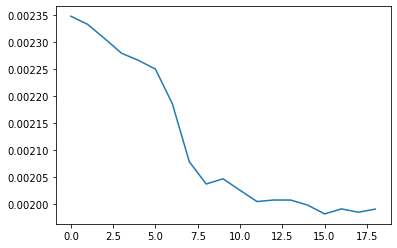

In [67]:
# Input encoder
input_shape = trainData.shape[1:]

optimizer = keras.optimizers.Adam(
  learning_rate=0.001,
  beta_1=0.9,
  beta_2=0.999,
)

lossFunction = keras.losses.MeanSquaredError() # l2

activationFunction = lambda x: tf.keras.activations.relu(x, max_value=255)
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=3)

autoencoder = keras.Sequential([
  layers.Conv2D(32,(3,3), 2, padding='same', activation='relu', input_shape=input_shape),
  layers.Conv2D(32,(3,3), 2, padding='same', activation='relu'),
  layers.Conv2D(16,(3,3), 2, padding='same', activation='relu', name='displayable_encoder'),

  layers.Flatten(name='encoder'),
  layers.Reshape(target_shape=(8,8,16)),

  layers.Conv2DTranspose(32,(3,3), 2, padding='same', activation='relu'),
  layers.Conv2DTranspose(32,(3,3), 2, padding='same', activation='relu'),
  layers.Conv2DTranspose(3, (3,3), 2, padding='same', activation='sigmoid', name='decoder'),
])

autoencoder.compile(optimizer=optimizer, loss=lossFunction)

print('Encoder shape:',autoencoder.get_layer('encoder').output_shape)

result = autoencoder.fit(trainData[:len(lightCoords)], trainData[:len(lightCoords)],
                          epochs=50,
                          batch_size=2,
                          shuffle=True,
                          verbose=0,
                          callbacks=[
                            TqdmCallback(verbose=1), # Concise display progression
                            earlyStop,
                          ],
                        )

matPlt.plot(result.history['loss'][10:], label='Training')
autoencoder.summary()

encoder = keras.Model(inputs=autoencoder.inputs, outputs=autoencoder.get_layer('encoder').output)

Test display some tiles
Original data: (40, 64, 64, 3)


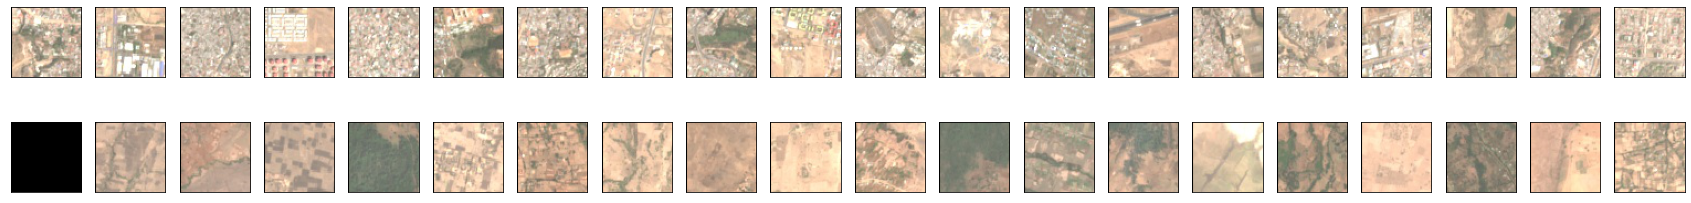

2/2 [==============================] - 0s 9ms/step
Output data: (40, 64, 64, 3)


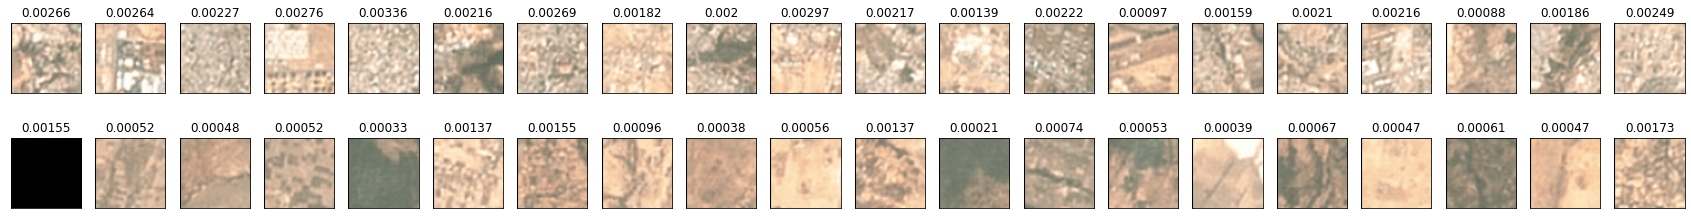

In [68]:
print("Test display some tiles")

indexesTest = [*np.argwhere(lightMask)[100:600:25].flatten(), *range(0,100000,5000)]

with rasterio.open(pathSatellite) as f:
  dataTest, _ = utils.coordsToImgsFormated(f, dataCoords[indexesTest], res=64)

utils.displayAutoEncoderResults(autoencoder, dataTest, showDetail=0, precision=5)

In [ ]:
'''
autoencoder = keras.models.load_model('model/autoencoder_64px_encoder_1024')
encoder = keras.Model(inputs=autoencoder.inputs, outputs=autoencoder.get_layer('encoder').output)
'''

In [69]:
train = encoder.predict(trainData)
validation = np.concatenate((dataRadiance[lightMask], dataRadiance[darkMask][::steps]))

163/163 [==============================] - 1s 6ms/step


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 1024)]            0         
                                                                 
 dense_26 (Dense)            (None, 256)               262400    
                                                                 
 dense_27 (Dense)            (None, 64)                16448     
                                                                 
 dense_28 (Dense)            (None, 1)                 65        
                                                                 
Total params: 278,913
Trainable params: 278,913
Non-trainable params: 0
_________________________________________________________________


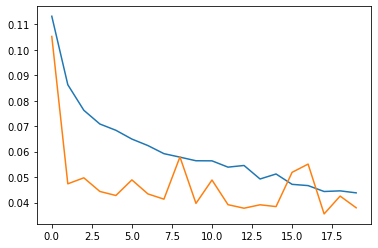

In [70]:
# Input encoder
input_shape = keras.Input(shape=train.shape[1:])

optimizer = keras.optimizers.Adam(
  learning_rate=0.0001,
  beta_1=0.9,
  beta_2=0.999,
)
lossFunction = keras.losses.MeanSquaredError() # l2

activationFunction = 'relu'

earlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=5)

cnn = layers.Dense(256, activation=activationFunction)(input_shape)
cnn = layers.Dense(64, activation=activationFunction)(cnn)
cnn = layers.Dense(1, activation='sigmoid')(cnn)

model = keras.Model(input_shape, cnn)
model.compile(optimizer=optimizer, loss=lossFunction)

result = model.fit(
  x=train[::2],
  y=validation[::2],
  epochs=20,
  batch_size=4,
  sample_weight=validationWeight[::2],
  verbose=0,
  validation_data=(train[1::2],validation[1::2]),
  callbacks=[
    TqdmCallback(verbose=1), # Concise display progression
    earlyStop,
  ],
)

matPlt.plot(result.history['loss'][:], label='Training')
matPlt.plot(result.history['val_loss'][:], label='test')
model.summary()

## Analyse model

In [71]:
print('Process score...')
getScore = lambda data : model.predict(encoder.predict(data, verbose=0), verbose=0).flatten()
result = utils.scanSatellite(pathSatellite, dataCoords, getScore, batch=1000, res=64)

Process score...


### Confusion Matrix. 

In [76]:
threshold = 0.095
resultTest = (np.asarray(result) > threshold).astype(int)

utils.processConfusionMatrix(resultTest, resultValid, lightMask)

Total light data: 1881 Detected: 1694 Missed: 187
Population with light detected: 90.06 %

Process confustion matrix...
total data: 137637
[[82964 37451]
 [ 9062  8160]]
f-score: 25.97 %


# Display the analysed results

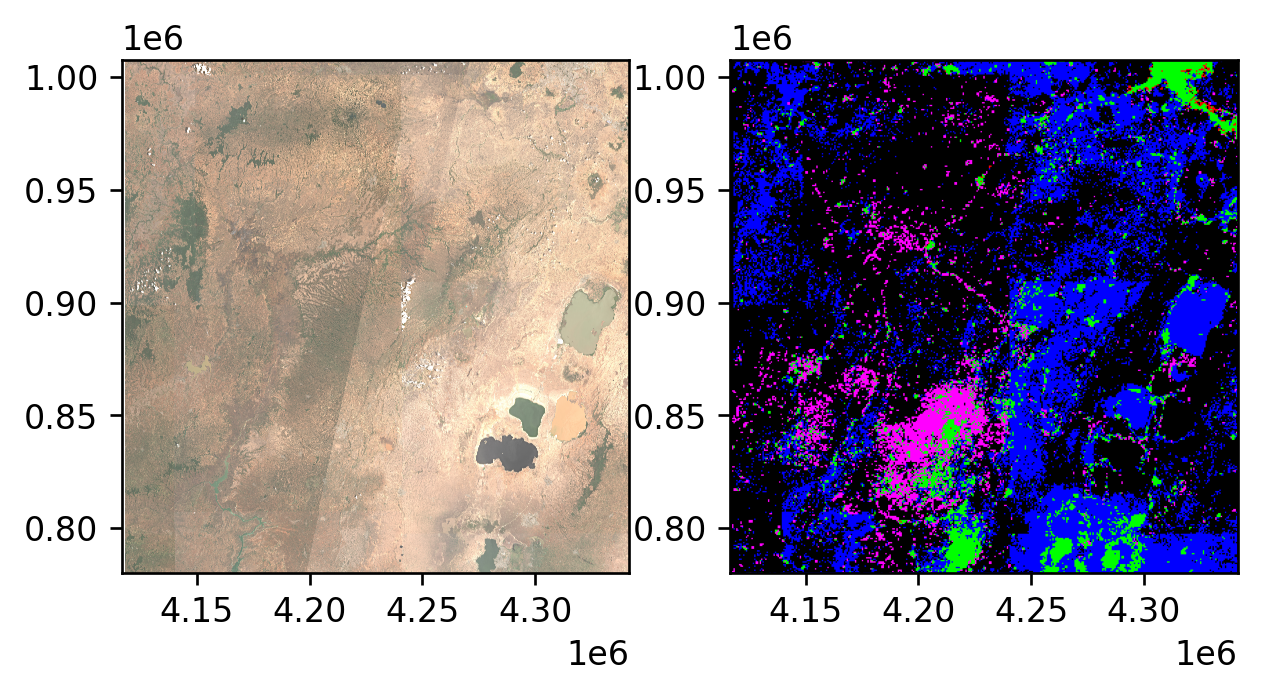

In [77]:
resultImg, resultMeta = utils.mapResultOnImg(pathNight, dataCoords, resultTest, resultValid, lightMask)

fig, axs = matPlt.subplots(1,2, dpi=240)
with rasterio.open(pathSatellite) as s: utils.displayTiles([s.read()], [s.transform],axs[0])

axs[1].set_xlim(axs[0].get_xlim())
axs[1].set_ylim(axs[0].get_ylim())

utils.displayTiles([resultImg], [resultMeta], axs[1])


## save result

In [78]:
autoencoder.save('model/autoencoder_64px_encoder_1024_Ethiopie')
model.save('model/autoencoder_perceptron_64px_dense256_dense64_Ethiopie')

INFO:tensorflow:Assets written to: model/autoencoder_64px_encoder_1024_Ethiopie\assets


INFO:tensorflow:Assets written to: model/autoencoder_64px_encoder_1024_Ethiopie\assets


INFO:tensorflow:Assets written to: model/autoencoder_perceptron_64px_dense256_dense64_Ethiopie\assets


INFO:tensorflow:Assets written to: model/autoencoder_perceptron_64px_dense256_dense64_Ethiopie\assets


In [79]:
img, profile = utils.rasterToImg(resultImg, pathNight)
with rasterio.open(folderName + 'autoencoder_perceptron_64px_dense256_dense64_Ethiopie.tif', 'w', **profile) as f:
  f.write(img)